In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [133]:
from pyemma.msm import HMSM
import numpy as np
from scipy.stats import binom, entropy

In [75]:
from pyemma.msm import MaximumLikelihoodHMSM, MaximumLikelihoodMSM
from bhmm import lag_observations
from bhmm.hidden.api import forward, viterbi

In [205]:
def bic(hmm):
    p, ndata = dof(hmm)
    loglike = hmm.likelihood # log likelihood
    return np.log(ndata)*p - 2*loglike

def icl(hmm):
    ent = np.sum([entropy(gamma_i.T) for gamma_i in hmm.hidden_state_probabilities])
    return ent + bic(hmm)


def aic(hmm):
    p, _ = dof(hmm)
    loglike = hmm.likelihood # log likelihood    
    return 2*p - 2*loglike

def dof(hmm):
    n = int(np.sum(hmm.count_matrix)) # Number of data points
    N = hmm.metastable_distributions.shape[0] # Num hidden states
    M = hmm.metastable_distributions.shape[1] # Num observed states
    
    # Shouldn't be needed - need to check. 
    assert hmm.count_matrix.shape[0] == N
    
    dof = N*(M-1) # Emission probabilities add to one.
    if hmm.reversible:
        dof += (1/2)*N*(N-1) + N - 1
    else:
        dof += N*(N-1)

    dof = int(dof)

#     or hmm.observe_nonempty  - don't need this (I think)

    if (hmm.separate is not None) or (hmm.connectivity is None) or \
        hmm.connectivity=='all':
        print("BIC/AIC not available for these constraints")
        return None, None
    else:
        return dof, n
    

## Create/load trajs

In [211]:
P = np.array([[0.7, 0.2, 0.1], [0.2, 0.6, 0.2], [0.1, 0.2, 0.7]])
m = 50
pobs = np.array([[binom(n=m-1, p=x).pmf(y) for y in range(m)] for x in [0.1, 0.5, 0.9] ])
hmm = HMSM(P, pobs)

In [212]:
if True:
    trajs = [hmm.simulate(int(1e3)) for _ in range(100)]
    otrajs = [x for (_, x) in trajs]
    np.save('otrajs.npy', otrajs)
else:
    otrajs = np.load('otrajs.npy')
    otrajs = [x for x in otrajs]

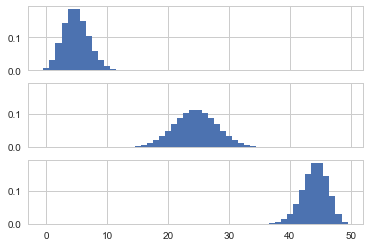

In [213]:
fig, axes = plt.subplots(P.shape[0], sharex=True, sharey=True)
for i, ax in enumerate(axes):
    ax.bar(np.arange(pobs.shape[1]), pobs[i], width=1)

## Estimate from otraj

In [214]:
# np.set_printoptions(edgeitems=3,infstr='inf',linewidth=75, nanstr='nan', precision=8,suppress=False, threshold=1000, formatter=None)

In [215]:
m = MaximumLikelihoodHMSM(nstates=3, lag=1, stationary=False, reversible=True, connectivity='largest')

In [216]:
m.fit(otrajs)

MaximumLikelihoodHMSM(accuracy=0.001, connectivity='largest',
           dt_traj='1 step', lag=1, maxit=1000,
           mincount_connectivity=0.3333333333333333,
           msm_init='largest-strong', nstates=3, observe_nonempty=True,
           reversible=True, separate=None, stationary=False, stride=1)

In [217]:
# np.set_printoptions(formatter={'float': lambda x: '{:4.0f}'.format(x) })
print(np.array2string(m.P*100, precision=0))
print(np.array2string(P*100, precision=0))

[[61. 20. 19.]
 [20. 70. 10.]
 [20. 10. 70.]]
[[70. 20. 10.]
 [20. 60. 20.]
 [10. 20. 70.]]


In [218]:
print(np.array2string(m.observation_probabilities*100,formatter={'float': lambda x: '{:4.2f}'.format(x)}))
print(np.array2string(pobs*100,formatter={'float': lambda x: '{:4.2f}'.format(x)}))



[[0.02 0.00 0.00 0.07 0.01 0.00 0.11 0.14 0.00 0.00 0.01 0.00 0.05 0.03
  0.12 0.30 0.49 1.08 2.09 3.28 4.98 6.76 9.07 10.25 11.17 11.26 10.23
  8.78 6.58 5.22 3.23 2.00 1.14 0.63 0.27 0.13 0.05 0.01 0.00 0.00 0.00
  0.00 0.05 0.00 0.05 0.12 0.04 0.18 0.00 0.00]
 [0.00 0.04 0.00 0.06 0.00 0.00 0.00 0.00 0.01 0.01 0.01 0.00 0.00 0.00
  0.02 0.00 0.00 0.03 0.02 0.08 0.00 0.12 0.00 0.00 0.00 0.00 0.00 0.01
  0.01 0.06 0.02 0.10 0.04 0.00 0.01 0.00 0.03 0.23 0.58 1.29 3.13 6.28
  10.23 15.14 18.53 18.00 14.29 8.11 3.01 0.49]
 [0.53 3.13 8.39 14.35 18.37 18.38 15.08 10.11 5.86 2.99 1.35 0.59 0.19
  0.09 0.00 0.00 0.04 0.03 0.00 0.00 0.04 0.03 0.00 0.01 0.01 0.04 0.03
  0.11 0.07 0.01 0.00 0.00 0.01 0.00 0.00 0.01 0.01 0.00 0.01 0.00 0.00
  0.00 0.00 0.01 0.00 0.02 0.05 0.02 0.00 0.00]]
[[0.57 3.12 8.31 14.47 18.49 18.49 15.07 10.28 6.00 3.04 1.35 0.53 0.19
  0.06 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.

## State selection

In [219]:
ks = np.arange(2,5)
results = {'k': [], 'bic': [], 'aic': [], 'icl': []}
for k in ks:
    m = MaximumLikelihoodHMSM(nstates=int(k), lag=1, stationary=False, reversible=True, connectivity='largest')
    m.fit(otrajs)
    results['k'].append(k)
    results['bic'].append(bic(m))
    results['aic'].append(aic(m))
    results['icl'].append(icl(m))


    

In [220]:
df = pd.DataFrame(results)
df = pd.melt(frame=df, id_vars='k', value_name='score', var_name='criterion')


In [221]:
min_scores = df.groupby('criterion')['score'].transform('min')
idx = df['score'] == min_scores
best = df.loc[idx, :]

In [222]:
criteria = df['criterion'].unique()

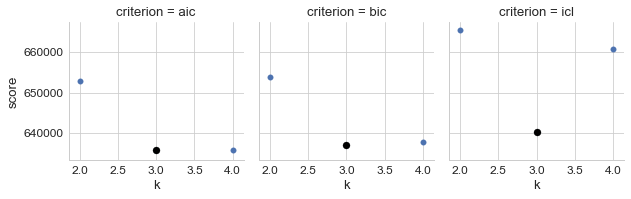

In [223]:
with sns.plotting_context('paper', font_scale=1.5):
    sns.set_style('whitegrid')
    g = sns.FacetGrid(data=df, col='criterion', col_order=criteria)
    g.map(plt.scatter, 'k', 'score')
    for i, ax in enumerate(g.axes.flatten()):
        idx = best['criterion']==criteria[i]
        ax.scatter(best.loc[idx, 'k'],best.loc[idx, 'score'] , marker='o',s=50, color='k')
    # g.set(yscale='log')

## Check likelihood calculation

In [36]:
m.likelihood

-149626.81879578144

In [37]:
p0 = m.initial_distribution
P = m.P
pobs = m.observation_probabilities

In [38]:
ll = 0
for traj in otrajs:
    pobs_i = pobs.T[traj]
    ll += forward(A=P, pobs=pobs_i, pi=p0 )[0]

In [39]:
ll - m.likelihood

0.00098842673469334841

## Check lagged model likelihood

In [60]:
m2 = MaximumLikelihoodHMSM(nstates=3, lag=5, stationary=False)
m2.fit(otrajs)

MaximumLikelihoodHMSM(accuracy=0.001, connectivity=None, dt_traj='1 step',
           lag=5, maxit=1000, mincount_connectivity=0.3333333333333333,
           msm_init='largest-strong', nstates=3, observe_nonempty=True,
           reversible=True, separate=None, stationary=False, stride=1)

In [61]:
m2.likelihood

-158763.87363004734

In [62]:
p0 = m2.initial_distribution
P = m2.P
pobs = m2.observation_probabilities

In [63]:
lagged_otrajs = lag_observations(otrajs, lag=5, stride=1)

ll = 0
for traj in lagged_otrajs:
    pobs_i = pobs.T[traj]
    ll += forward(A=P, pobs=pobs_i, pi=p0 )[0]
print(ll)

-158763.872851


## Overflow safe forward function

In [69]:
def forward(A, pobs, pi, T=None, alpha_out=None, dtype=np.float32):
    """Compute P( obs | A, B, pi ) and all forward coefficients.

    Parameters
    ----------
    A : ndarray((N,N), dtype = float)
        transition matrix of the hidden states
    pobs : ndarray((T,N), dtype = float)
        pobs[t,i] is the observation probability for observation at time t given hidden state i
    pi : ndarray((N), dtype = float)
        initial distribution of hidden states
    T : int, optional, default = None
        trajectory length. If not given, T = pobs.shape[0] will be used.
    alpha_out : ndarray((T,N), dtype = float), optional, default = None
        container for the alpha result variables. If None, a new container will be created.
    dtype : type, optional, default = np.float32
        data type of the result.

    Returns
    -------
    logprob : float
        The probability to observe the sequence `ob` with the model given
        by `A`, `B` and `pi`.
    alpha : ndarray((T,N), dtype = float), optional, default = None
        alpha[t,i] is the ith forward coefficient of time t. These can be
        used in many different algorithms related to HMMs.

    """
    from decimal import Decimal as dec
    
    # set T
    if T is None:
        T = pobs.shape[0]  # if not set, use the length of pobs as trajectory length
    elif T > pobs.shape[0]:
        raise ValueError('T must be at most the length of pobs.')
    # set N
    N = A.shape[0]
    # initialize output if necessary
    if alpha_out is None:
        alpha_out = np.zeros((T, N), dtype=dtype)
    elif T > alpha_out.shape[0]:
        raise ValueError('alpha_out must at least have length T in order to fit trajectory.')
    # log-likelihood
    logprob = dec(0.0)

    # initial values
    # alpha_i(0) = pi_i * B_i,ob[0]
    np.multiply(pi, pobs[0, :], out=alpha_out[0])

    # scaling factor
    scale = np.sum(alpha_out[0, :])
    # scale
    alpha_out[0, :] /= scale
    logprob += dec(float(np.log(scale)))

    # induction
    for t in range(T-1):
        # alpha_j(t+1) = sum_i alpha_i(t) * A_i,j * B_j,ob(t+1)
        np.multiply(np.dot(alpha_out[t, :], A), pobs[t+1, :], out=alpha_out[t+1])
        # scaling factor
        scale = np.sum(alpha_out[t+1, :])
        # scale
        alpha_out[t+1, :] /= scale
        # update logprob
        logprob += dec(float(np.log(scale)))

    return logprob, alpha_out

In [72]:
lagged_otrajs = lag_observations(otrajs, lag=5, stride=1)

ll = 0
for traj in lagged_otrajs:
    pobs_i = pobs.T[traj]
    ll += forward(A=P, pobs=pobs_i, pi=p0 )[0]
print(ll)
print(m2.likelihood)

-158763.8728513717651367187500
-158763.87363


## Use CV likelihood.  

In [46]:
from sklearn.model_selection import ShuffleSplit

In [47]:
cv = ShuffleSplit(n_splits=20, random_state=42, test_size=0.5)


In [50]:
ns = [3]
results = {'n': [], 'test_ll': [], 'train_ll': []}
for te_idx, tr_idx in cv.split(otrajs):
    train = [otrajs[i] for i in tr_idx]
    test = [otrajs[i] for i in te_idx]
    for n in ns: 
        print(n,end=', ')
        results['n'].append(n)
        
        msm = MaximumLikelihoodMSM(lag=1)
        msm.fit(train)
        m = MaximumLikelihoodHMSM(nstates=n, lag=1, accuracy=1e-3, msm_init=msm)
        
        # Train
        m.fit(train)
        results['train_ll'].append(m.likelihood)
        
        # test
        p0 = m.initial_distribution
        P = m.P
        pobs = m.observation_probabilities
        ll = 0
        for traj in test:
            pobs_i = pobs.T[traj]
            ll += forward(A=P, pobs=pobs_i, pi=p0 )[0]
        print(ll)
        results['test_ll'].append(ll)


3, -133892.2181742255
3, -134094.13048129895
3, -133987.6088794739
3, -134052.21034127538
3, -133826.25019003561
3, -133833.2463111336
3, -133834.1201851915
3, 

KeyboardInterrupt: 

In [232]:
df = pd.DataFrame(results)
df = pd.melt(frame=df, id_vars='n')
df.head()

,n,variable,value
0,2,test_ll,-75082.178718
1,3,test_ll,-74735.525458
2,4,test_ll,-74744.711259
3,2,test_ll,-75303.552415
4,3,test_ll,-74977.273064


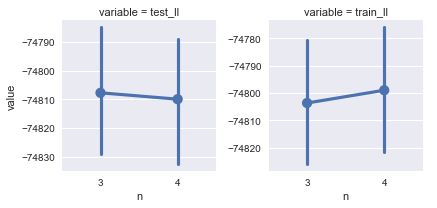

In [237]:
g = sns.FacetGrid(data=df.loc[df['n']>2], col='variable', sharey=False)
g.map(sns.pointplot, 'n','value').add_legend()

In [234]:
df.groupby(['variable', 'n']).aggregate([np.median, np.std])

value           
                  median        std
variable n                         
test_ll  2 -75143.714727  74.345599
         3 -74818.750012  79.528968
         4 -74820.498888  79.082980
train_ll 2 -75137.501713  74.821671
         3 -74789.480346  79.615485
         4 -74783.408136  79.807476

In [235]:
m = MaximumLikelihoodHMSM(nstates=n, lag=1)
m.fit(otrajs[:50])
m.likelihood

KeyboardInterrupt: 

In [188]:
# test
p0 = m.initial_distribution
P = m.P
pobs = m.observation_probabilities
ll = 0
for traj in otrajs[50:]:
    pobs_i = pobs.T[traj]
    ll += forward(A=P, pobs=pobs_i, pi=p0 )[0]
# results['test_ll'].append(ll)
ll

-74986.53917404336